In [119]:
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np
pio.renderers.default = "svg"
import re
import plotly.graph_objects as go
from pyspark.sql.functions import col, split, explode, regexp_replace, transform, when
from pyspark.sql import functions as F
from pyspark.sql.functions import col, monotonically_increasing_id

np.random.seed(42)

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# df.printSchema() # comment this line when rendering the submission
# df.show(5)

# Companies Table

In [120]:
companies_df = df.select(
    col("company"),
    col("company_name"),
    col("company_raw"),
    col("company_is_staffing")
).distinct().withColumn("company_id", monotonically_increasing_id())

companies = companies_df.toPandas()
companies.drop(columns=["company"], inplace=True)
companies.to_csv("./output/companies.csv", index=False)
companies.head()

company_name  \
0                                              Crowe   
1                            The Devereux Foundation   
2                                     Elder Research   
3                                           NTT DATA   
4  Frederick National Laboratory For Cancer Research   

                                         company_raw company_is_staffing  \
0                                              Crowe               False   
1                            The Devereux Foundation               False   
2                                     Elder Research               False   
3                                       NTT DATA Inc               False   
4  Frederick National Laboratory for Cancer Research               False   

   company_id  
0           0  
1           1  
2           2  
3           3  
4           4

# Data Preparation (Clean Up Data)

In [121]:
#Step 1: Casting Salary and Experience Columns
df = df.withColumn("SALARY_FROM", col("SALARY_FROM").cast("float")) \
       .withColumn("SALARY", col("SALARY").cast("float")) \
       .withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float")) \
       .withColumn("MIN_YEARS_EXPERIENCE", col("MIN_YEARS_EXPERIENCE").cast("float")) \
       .withColumn("SALARY_TO", col("SALARY_TO").cast("float")) \

#Step 2: Computing medians for salary columns
def compute_median(sdf, col_name):
  q = sdf.approxQuantile(col_name, [0.5], 0.01)
  return q[0] if q else None

median_from = compute_median(df, "SALARY_FROM")
median_to = compute_median(df, "SALARY_TO")
median_salary =  compute_median(df, "SALARY")

print("Medians :", median_from, median_to, median_salary)

# df = df.withColumn("SALARY", when(
#     col("SALARY").isNotNull() & (col("SALARY") > 0),
#     col("SALARY")
# ).otherwise((col("SALARY_FROM") + col("SALARY_TO")) / 2))

# df = df.withColumn("SALARY", (col("SALARY_FROM") + col("SALARY_TO")) / 2)

df = df.fillna({
    "SALARY_FROM": median_from,
    "SALARY_TO": median_to,
})

df = df.withColumn("Average_Salary", (col("SALARY_FROM") + col("SALARY_TO")) / 2)

export_cols = [
  "EDUCATION_LEVELS_NAME",
  "REMOTE_TYPE_NAME",
  "MAX_YEARS_EXPERIENCE",
  "Average_Salary",
  "SALARY",
  "LOT_V6_SPECIALIZED_OCCUPATION_NAME"
]
df_selected = df.select(*export_cols)

pdf = df_selected.toPandas()
pdf.to_csv("./data/lightcast_cleaned.csv", index=False)

print("Data cleaning complete. Rows retained:", len(pdf))

Medians : 87295.0 130042.0 115024.0


Data cleaning complete. Rows retained: 72498


In [122]:
import pandas as pd
#filter out missing or zero salary values
from pyspark.sql.functions import col
pdf = df.filter(col("SALARY") > 0).select("EMPLOYMENT_TYPE_NAME", "SALARY").toPandas()
pdf.head()

EMPLOYMENT_TYPE_NAME    SALARY
0   Part-time / full-time   92500.0
1  Full-time (> 32 hours)  110155.0
2  Full-time (> 32 hours)   92962.0
3  Full-time (> 32 hours)  107645.0
4  Full-time (> 32 hours)  192800.0

In [123]:
import re

pdf["EMPLOYMENT_TYPE_NAME"] = pdf["EMPLOYMENT_TYPE_NAME"].apply(
    lambda x: re.sub(r"[^\x00-\x7F]+", "", x) if isinstance(x, str) else x
)
pdf.head()

EMPLOYMENT_TYPE_NAME    SALARY
0   Part-time / full-time   92500.0
1  Full-time (> 32 hours)  110155.0
2  Full-time (> 32 hours)   92962.0
3  Full-time (> 32 hours)  107645.0
4  Full-time (> 32 hours)  192800.0

In [124]:
# computer median salary for sorting
median_salary = pdf.groupby("EMPLOYMENT_TYPE_NAME")["SALARY"].median()
median_salary.head()

EMPLOYMENT_TYPE_NAME
Full-time (> 32 hours)    116500.0
Part-time ( 32 hours)      86390.0
Part-time / full-time     100000.0
Name: SALARY, dtype: float32

In [125]:
# Computer median salary for sorting
median_salaries = pdf.groupby("EMPLOYMENT_TYPE_NAME")["SALARY"].median()
median_salaries.head()

EMPLOYMENT_TYPE_NAME
Full-time (> 32 hours)    116500.0
Part-time ( 32 hours)      86390.0
Part-time / full-time     100000.0
Name: SALARY, dtype: float32

In [126]:
# Sort employment types based on median salary in descending order
sorted_employment_types = median_salaries.sort_values(ascending=False).index


pdf["EMPLOYMENT_TYPE_NAME"] = pd.Categorical(
  pdf["EMPLOYMENT_TYPE_NAME"],
  categories=sorted_employment_types,
  ordered=True
)

# Create Box Plot with horizontal grid lines
fig = px.box(
    pdf,
    x="EMPLOYMENT_TYPE_NAME",
    y="SALARY",
    title="Salary Distribution by Employment Type",
    color_discrete_sequence=["black"],
    boxmode="group",
    points="all",
)

#improve layout, font styles, and axis labels

fig.update_layout(
    title=dict(
        text="Salary Distribution by Employment Type",
        font=dict(size=30, family="Arial", color="black", weight="bold")
    ),
    xaxis=dict(
        title=dict(text="Employment Type", font=dict(size=24, family="Arial", color="black", weight="bold")),
        tickangle=0,
        tickfont=dict(size=18, family="Arial", color="black", weight="bold"),
        showline=True,
        linewidth=2,
        linecolor="black",
        mirror=True,
        showgrid=False,
        categoryorder="array",
        categoryarray=sorted_employment_types.tolist()
    ),
    yaxis=dict(
        title=dict(text="Salary (K $)", font=dict(size=24, family="Arial", color="black", weight="bold")),
        tickvals=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000],
        ticktext=["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K", "400K", "450K", "500K"],
        tickfont=dict(size=18, family="Arial", color="black", weight="bold"),
        showline=True,
        linewidth=2,
        linecolor="black",
        mirror=True,
        showgrid=True,
        gridcolor="lightgrey",
        gridwidth=0.5
    ),
    font=dict(family="Arial", size=16, color="black"),
    boxgap=0.7,
    plot_bgcolor="white",
    paper_bgcolor="white",
    showlegend=False,
    height=500,
    width=850
)
fig.show()
fig.write_image("./output/boxplot_employment_type_salary.png", scale=1)

# Salary Distribution by Industry and Employment Type 



    Compare salary variations across industries.
    Filter the dataset
        Remove records where salary is missing or zero.
    Aggregate Data
        Group by NAICS industry codes.
        Group by employment type and compute salary distribution.
    Visualize results
        Create a box plot where:
            X-axis = NAICS2_NAME
            Y-axis = SALARY_FROM
            Group by EMPLOYMENT_TYPE_NAME.
        Customize colors, fonts, and styles.
    Explanation: Write two sentences about what the graph reveals.


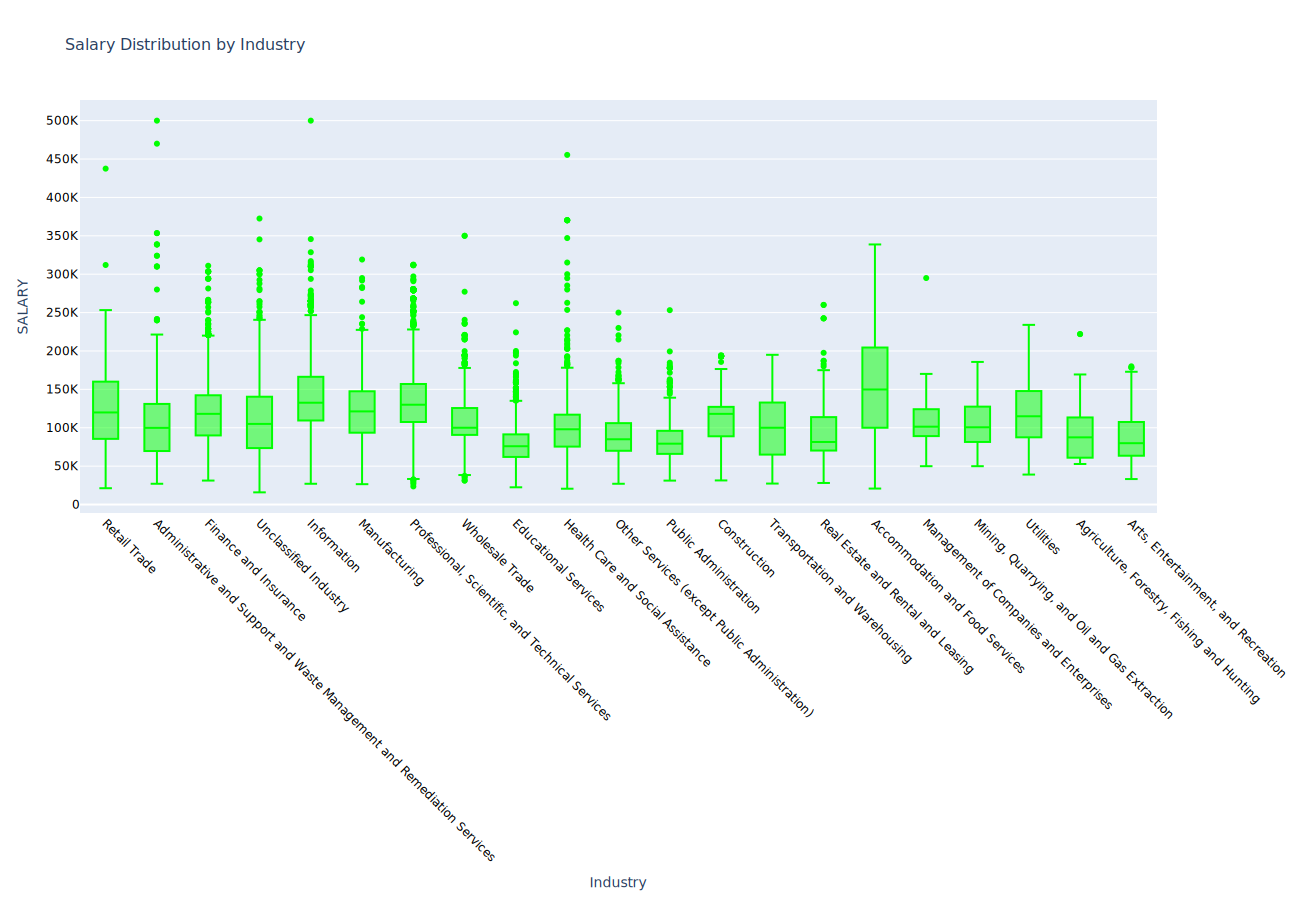

In [127]:
eval:True
import plotly.express as px

pdf = df.select("NAICS2_NAME", "SALARY").toPandas()

fig = px.box(
    pdf,
    x="NAICS2_NAME",
    y="SALARY",
    title="Salary Distribution by Industry",
    color_discrete_sequence=["#00ff00"]
)

fig.update_layout(
    font_family="Calibri",
    title_font_size=16,
    width=1300,
    height=900,
    yaxis=dict(
        tickvals=[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000],
        ticktext=["0", "50K", "100K", "150K", "200K", "250K", "300K", "350K", "400K", "450K", "500K"],
        tickfont=dict(size=12, family="Calibri", color="black")
    )
)

fig.update_xaxes(
    title="Industry",
    tickangle=45,
    tickfont=dict(size=12, family="Calibri", color="black")
)

fig.show()

Two sentencences that the graph reveals - This graph reveals the high and low end of jobs while displaying the outliers in an easy to read graphic for specific industries. Noted here is the large difference in accommodation and food services, which can have a large range from 100k to as high as roughly 200k median, while some other jobs such as education services could have a median of roughly 60k to 80k.

# 3 Salary Analysis by ONET Occupation Type (Bubble Chart)
--Appendix 1: Asked Copilot to help, as my aggregation was not workiong correctly, but it was because of a mix of the aggregation and the sorting that we had done in the saturday help session. AI prompts attached.

    Analyze how salaries differ across ONET occupation types.
    Aggregate Data
        Compute median salary for each occupation in the ONET taxonomy.
    Visualize results
        Create a bubble chart where:
            X-axis = ONET_NAME
            Y-axis = Median Salary
            Size = Number of job postings
        Apply custom colors and font styles.
    Explanation: Write two sentences about what the graph reveals.


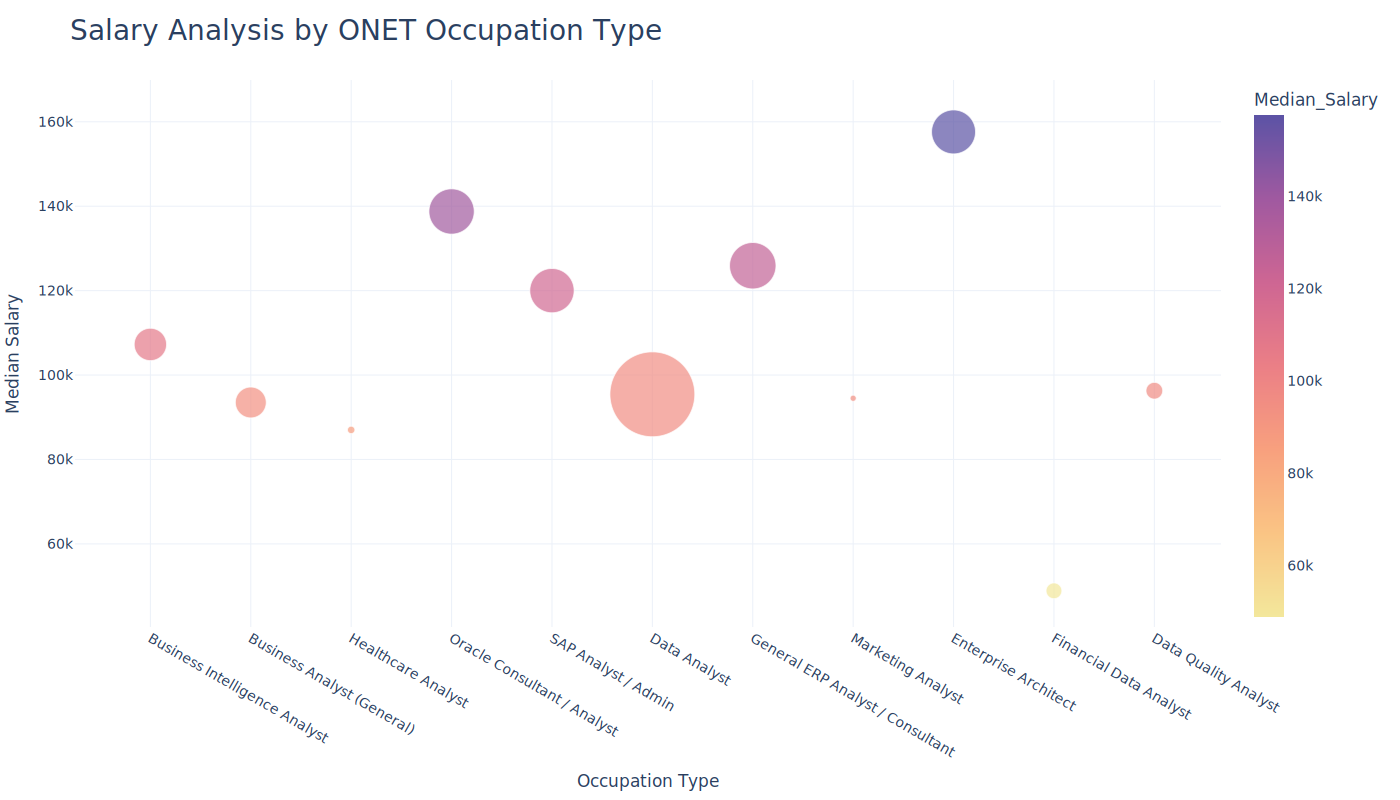

In [128]:
from pyspark.sql.functions import col, expr, count
import plotly.express as px

valid_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull()
)

valid_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull() &
    (col("LOT_V6_SPECIALIZED_OCCUPATION_NAME") != "")
)

agg_df = df.filter(
    col("SALARY").isNotNull() & (col("SALARY") > 0) &
    col("LOT_V6_SPECIALIZED_OCCUPATION_NAME").isNotNull() &
    (col("LOT_V6_SPECIALIZED_OCCUPATION_NAME") != "")
).groupBy("LOT_V6_SPECIALIZED_OCCUPATION_NAME") \
 .agg(
    expr("percentile_approx(SALARY, 0.5, 100)").alias("Median_Salary"),
    count("*").alias("Job_Postings")
).withColumnRenamed("LOT_V6_SPECIALIZED_OCCUPATION_NAME", "Occupation_Name")

# Converting to pandas
bubble_pdf = agg_df.toPandas()

# Buble Chart
fig = px.scatter(
    bubble_pdf,
    x="Occupation_Name",
    y="Median_Salary",
    size="Job_Postings",
    color="Median_Salary",
    color_continuous_scale="sunset",
    title="Salary Analysis by ONET Occupation Type",
    hover_name="Occupation_Name",
    size_max=60,
    template="plotly_white"
)

fig.update_layout(
    xaxis_title="Occupation Type",
    yaxis_title="Median Salary",
    width=1400,
    height=800,
    font=dict(family="Calibri", size=14),
    title_font=dict(size=28),
    margin=dict(l=40, r=40, t=80, b=120)
)

fig.show()

Two sentencences that the graph reveals - This graph reveals that Data analysts may have the biggest field and the most data sets, but enterprise architexts make the most money on average based on the jobs in this data set.Speciality jobs that have specific skills also seem to have higher pay as opposed to general jobs like business analyst, unlike business intelligence analysts who have a higher average salary.

# 4 Salary by Education Level (Two Groups)

    Create two groups:
        Associate’s or lower (GED, Associate, No Education Listed)
        Bachelor’s (Bachelor’s degree)
        Master’s (Master’s degree)
        PhD (PhD, Doctorate, professional degree)
    Plot scatter plots for each group using, MAX_YEARS_EXPERIENCE (with jitter), Average_Salary, LOT_V6_SPECIALIZED_OCCUPATION_NAME
    After each graph, add a short explanation of key insights.

In [129]:
from pyspark.sql.functions import col, when

lower_deg = ["Bachelor's", "Associate", "GED", "No Education Listed", "High school"]
higher_deg = ["Master's degree", "Ph.D. or professional degree"]

# Create education group column
df = df.withColumn(
    "EDU_GROUP",
    when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in lower_deg])), "Bachelor's or lower")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in higher_deg])), "Master's or PhD")
    .otherwise("Other")
)

# Cast columns properly
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))
df = df.withColumn("Salary", col("Salary").cast("float"))

# Filter valid rows
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Salary") > 0)
)

# Filter by education group
df_filtered = df.filter(col("EDU_GROUP").isin(["Bachelor's or lower", "Master's or PhD"]))
# Convert to pandas
df_pd = df_filtered.toPandas()

In [130]:
import numpy as np

# Add jitter to experience values
df_pd["EXPERIENCE_JITTER"] = df_pd["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.3, 0.3, size=len(df_pd))

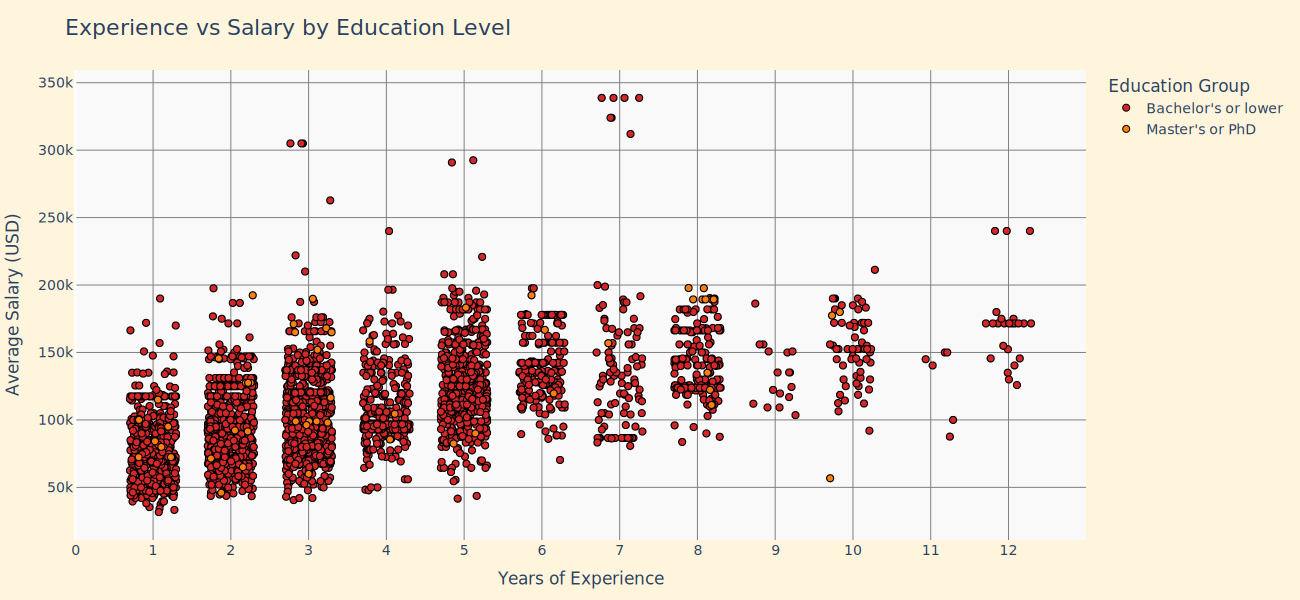

In [131]:
fig1 = px.scatter(
    df_pd,
    x="EXPERIENCE_JITTER",
    y="Salary",
    color="EDU_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="Experience vs Salary by Education Level",
    opacity=1,
    color_discrete_sequence=["#d62728", "#ff7f0e"],
    width=1300,
    height=600
)

fig1.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig1.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Education Group",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="gray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="gray")
)
# Needed to use iframe due to it being unable to render in preview with just show and not specifiying renderer
fig1.show()
fig1.write_html("output/q_1a_experience_vs_salary_by_education_level.html")

Two sentencences that the graph reveals - This graph reveals that masters programs can aid in getting you higher paying jobs in the beginning as an aid in replacing years of experience, and even over the longer term has shown in this graph to translate to higher average salaries. This could be multiple factors such as company requirements, but there are also outliers, such as the masters degree with 10 years of experience that has an average salary of roughly 60k.

# 4 Salary by Education Level (Four Groups)

    Create two groups:
        Associate’s or lower (GED, Associate, No Education Listed)
        Bachelor’s (Bachelor’s degree)
        Master’s (Master’s degree)
        PhD (PhD, Doctorate, professional degree)
    Plot scatter plots for each group using, MAX_YEARS_EXPERIENCE (with jitter), Average_Salary, LOT_V6_SPECIALIZED_OCCUPATION_NAME
    After each graph, add a short explanation of key insights.

In [132]:
from pyspark.sql.functions import col, when

lowest_deg = ["Associate", "GED", "No Education Listed", "High school"]
bach_deg = ["Bachelor's"]
mast_deg = ["Master's degree"]
phd_deg = ["Ph.D. or professional degree"]

# Create education group column
df = df.withColumn(
    "EDU_GROUP",
    when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in lowest_deg])), "Associate's or lower")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in bach_deg])), "Bachelor's")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in mast_deg])), "Master's")
    .when(col("EDUCATION_LEVELS_NAME").rlike("|".join([f"(?i){deg}" for deg in phd_deg])), "PhD")
    .otherwise("Other")
)

# Cast columns properly
df = df.withColumn("MAX_YEARS_EXPERIENCE", col("MAX_YEARS_EXPERIENCE").cast("float"))
df = df.withColumn("Salary", col("Salary").cast("float"))

# Filter valid rows
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Salary") > 0)
)

# Filter by education group
df_filtered2 = df.filter(col("EDU_GROUP").isin(["Associate's or lower", "Bachelor's", "Master's", "PhD"]))

# Convert to pandas
df_pd2 = df_filtered2.toPandas()

See appendix 2 -- asked ai to help me fix the data being in a straight line and it suggested the jitter.

In [133]:
import numpy as np

# Add jitter to experience values
df_pd2["EXPERIENCE_JITTER"] = df_pd2["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.3, 0.3, size=len(df_pd2))

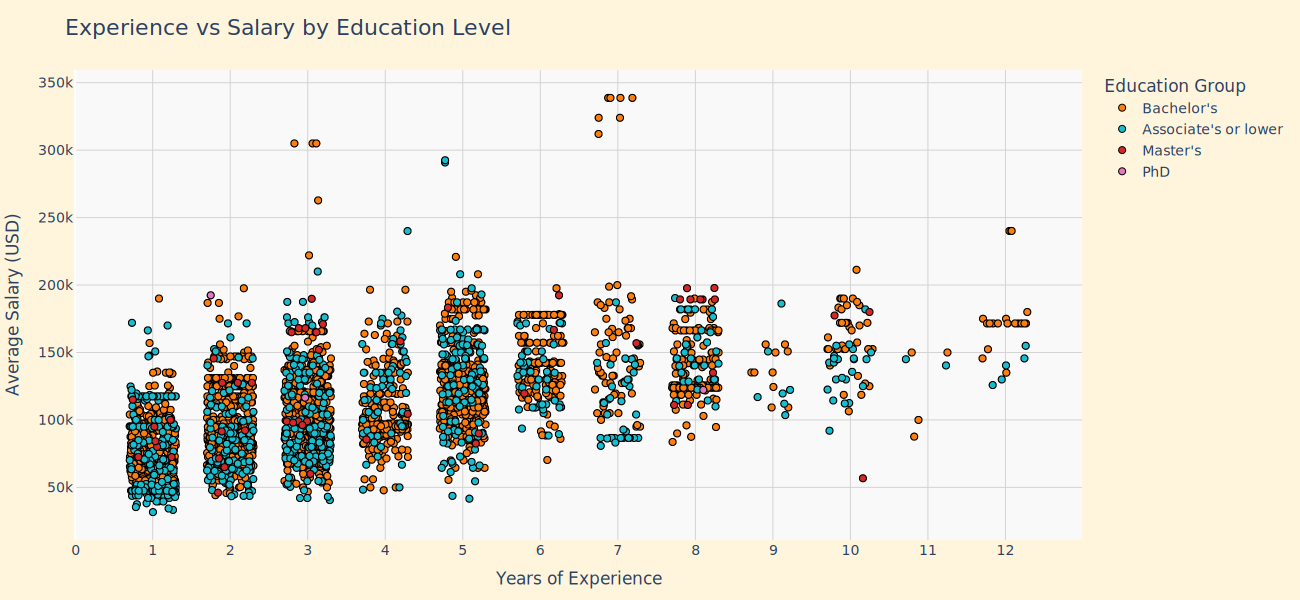

In [ ]:
fig2 = px.scatter(
    df_pd2,
    x="EXPERIENCE_JITTER",  # use jittered x-axis
    y="Salary",
    color="EDU_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="Experience vs Salary by Education Level",
    opacity=1,
    color_discrete_sequence=["#ff7f0e", "#17becf", "#d62728", "#e377c2", "#1f77b4"],
    width=1300,
    height=600
)

fig2.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig2.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Education Group",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="gray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="gray")
)
# Needed to use iframe due to it being unable to render in preview with just show and not specifiying renderer
fig2.show()
fig2.write_html("output/q_1a_experience_vs_salary_by_education_level_4.html")

Two sentencences that the graph reveals - This graph indicates that early in careers PhD holders can have an increased salary in the few cases noted, but over the long term years of experience translates to higher pay. Experience takes over as a key factor to salary according to this data with higher years of experience focusing on associates or lower and bachelors as opposed to higher level degrees.

In [135]:
from pyspark.sql.functions import col, when, trim
#Step 1
df = df.withColumn("REMOTE_GROUP",
    when(trim(col("REMOTE_TYPE_NAME")) == "Remote", "Remote")
    .when(trim(col("REMOTE_TYPE_NAME")) == "Hybrid Remote", "Hybrid")
    .when(trim(col("REMOTE_TYPE_NAME")) == "Not Remote", "Onsite")
    .when(col("REMOTE_TYPE_NAME").isNull(), "Onsite")
    .otherwise("Onsite")
)

#Step 2: Filter rows with valid values
df = df.filter(
    col("MAX_YEARS_EXPERIENCE").isNotNull() &
    col("Average_Salary").isNotNull() &
    (col("MAX_YEARS_EXPERIENCE") > 0) &
    (col("Average_Salary") > 0) 
)

# Step 3: Convert to pandas
df_pd = df.select(
    "MAX_YEARS_EXPERIENCE", "Average_Salary",
    "LOT_V6_SPECIALIZED_OCCUPATION_NAME", "REMOTE_GROUP"
).toPandas()

df_pd.head()

MAX_YEARS_EXPERIENCE  Average_Salary LOT_V6_SPECIALIZED_OCCUPATION_NAME  \
0                   2.0         92962.0                       Data Analyst   
1                   2.0         75026.0        Oracle Consultant / Analyst   
2                   1.0         60923.0                       Data Analyst   
3                   2.0        131100.0               Enterprise Architect   
4                   3.0        136950.0               Enterprise Architect   

  REMOTE_GROUP  
0       Onsite  
1       Onsite  
2       Remote  
3       Onsite  
4       Remote

In [136]:
# adding jitter

df_pd["MAX_YEARS_EXPERIENCE_JITTER"] = df_pd["MAX_YEARS_EXPERIENCE"] + np.random.uniform(-0.25,0.25,size=len(df_pd))
df_pd["AVERAGE_SALARY_JITTER"] = df_pd["Average_Salary"] + np.random.uniform(-2500,2500,size=len(df_pd))
df_pd = df_pd.round(2)
df_pd.head()

# removing outliers
df_pd = df_pd[df_pd["AVERAGE_SALARY_JITTER"] < 399000]

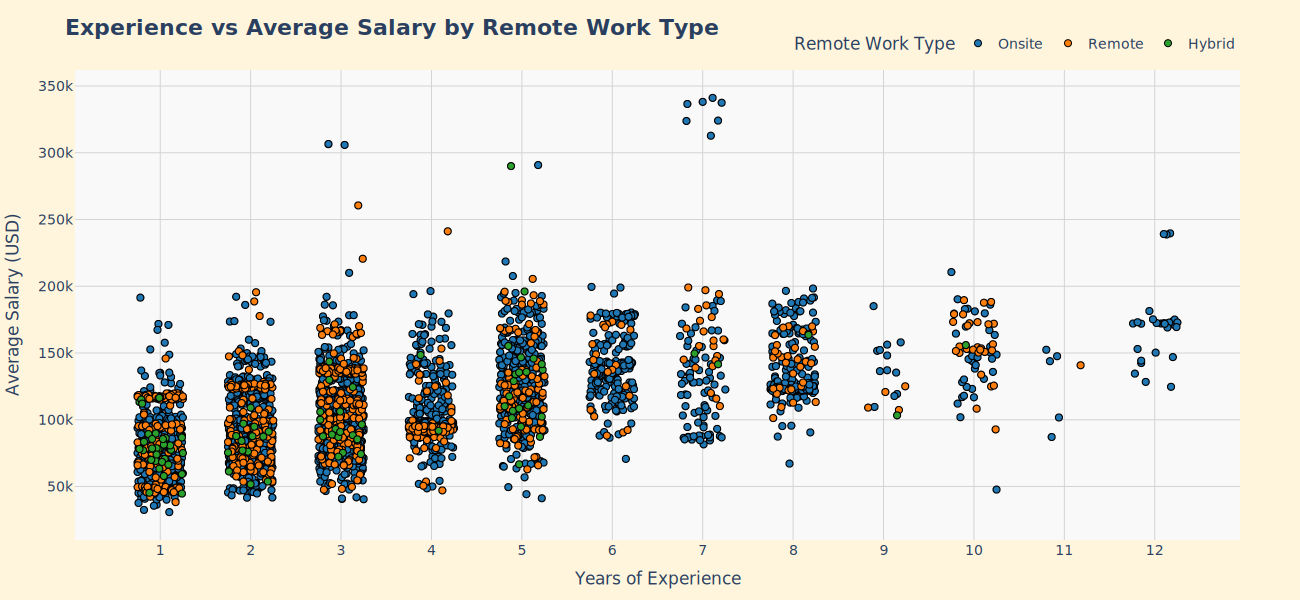

In [ ]:
fig4 = px.scatter(
    df_pd,
    x="MAX_YEARS_EXPERIENCE_JITTER",  # use jittered x-axis
    y="AVERAGE_SALARY_JITTER",
    color="REMOTE_GROUP",
    hover_data=["LOT_V6_SPECIALIZED_OCCUPATION_NAME"],
    title="<b>Experience vs Average Salary by Remote Work Type<b>",
    opacity=1,
    color_discrete_sequence=["#1f77b4", "#ff7f0e", "#2ca02c"],
    width=1300,
    height=600
)

fig4.update_traces(marker=dict(size=7, line=dict(width=1, color="black")))

fig4.update_layout(
    plot_bgcolor="#f9f9f9",
    paper_bgcolor="#fff5dc",
    font=dict(family="Segoe UI", size=14),
    title_font=dict(size=22),
    xaxis_title="Years of Experience",
    yaxis_title="Average Salary (USD)",
    legend_title="Remote Work Type",
    hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
    margin=dict(t=70, b=60, l=60, r=60),
    xaxis=dict(gridcolor="gray", tickmode="linear", dtick=1),
    yaxis=dict(gridcolor="gray"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig4.show()


Two sentencences that the graph reveals - This graph reveals that there isn't necessarily a direct correlation between years or experience, or a difference in salary based on remote work vs onsite work. There are higher salaries around the 7 year mark, but there is roughly an even looking mix based on the data in groups that indicate relatively equal pay between onsite and remote workers, with hybrid workers remaining in that median as well.

# Histrograms   

# Reference Appendix 3 for AI Prompt, had data but needed help formulating code to get all histographs in one.

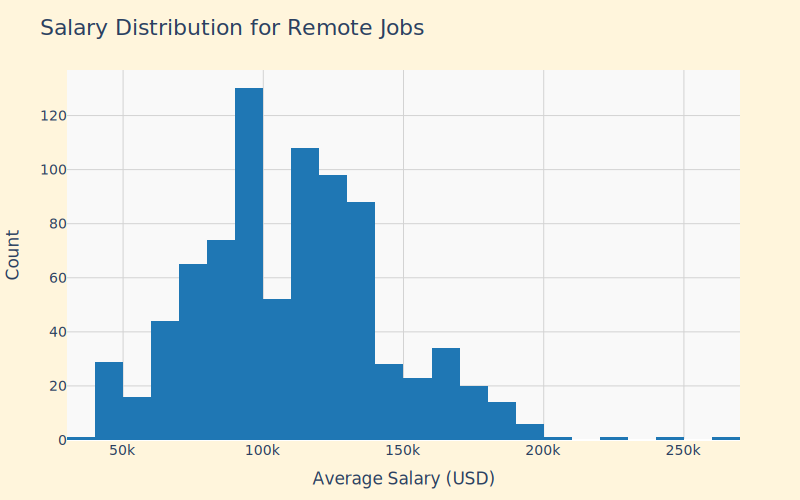

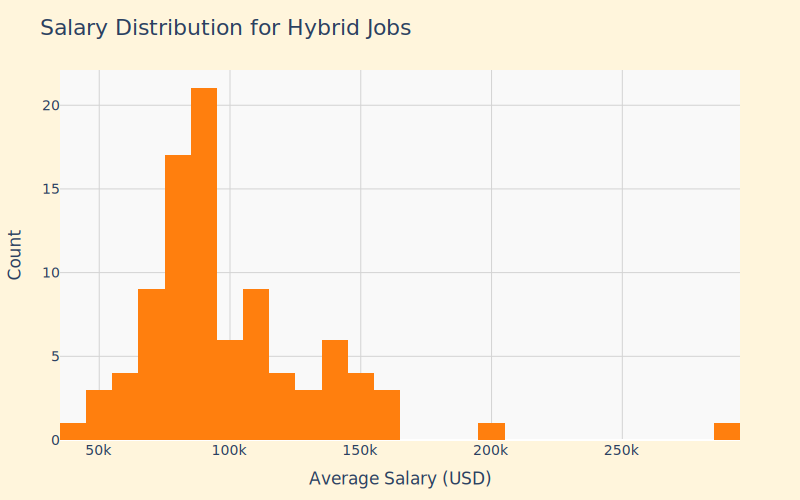

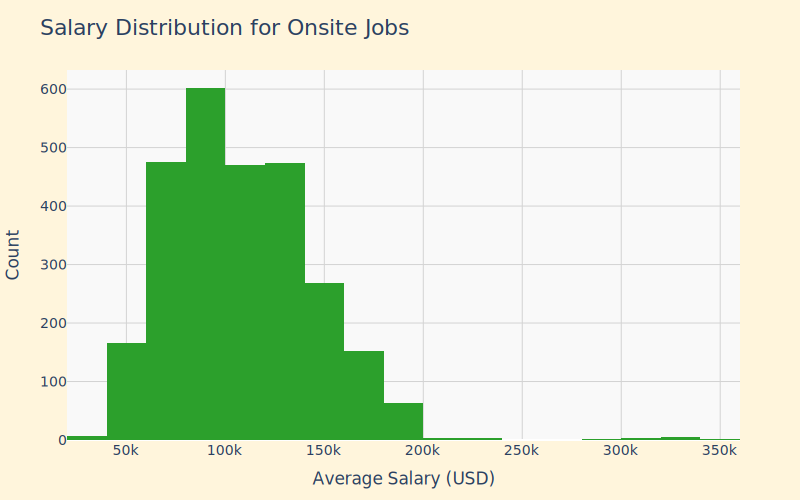

In [ ]:
import plotly.express as px

color_map = {
    "Remote": "#1f77b4",  # Blue
    "Hybrid": "#ff7f0e",  # Orange
    "Onsite": "#2ca02c"   # Green  
}

for group in ["Remote", "Hybrid", "Onsite"]:
    subset = df_pd[df_pd["REMOTE_GROUP"] == group]
    
    fig = px.histogram(
        subset,
        x="AVERAGE_SALARY_JITTER",
        nbins=30,
        title=f"Salary Distribution for {group} Jobs",
        color_discrete_sequence=[color_map[group]],
        width=800,
        height=500
    )

    fig.update_layout(
        plot_bgcolor="#f9f9f9",
        paper_bgcolor="#fff5dc",
        font=dict(family="Segoe UI", size=14),
        title_font=dict(size=22),
        xaxis_title="Average Salary (USD)",
        yaxis_title="Count",
        hoverlabel=dict(bgcolor="white", font_size=13, font_family="Arial"),
        margin=dict(t=70, b=60, l=60, r=60),
        xaxis=dict(gridcolor="gray"),
        yaxis=dict(gridcolor="gray")
    )
    fig.show()
    fig.write_html(f"output/salary_distribution_{group.lower()}.html")

Remote Jobs- For remote jobs, there seem to be less lower paying jobs, to me this means that the pattern is these are higher skilled jobs or jobs that require more experience, and allow for more flexibility in work location, which is why we see a gap in the left side of the histogram and it starts to make a mountain towards the 100k salary range. The same can be true though for the high paying positions as there are very few of them as well.

Hybrid Jobs - A similar trend here is seen only is is shifting to the right, where there are more jobs that are paying a but less and the peak is at around the 80k range as opposed to the remote job. There are also less data points to gather this information from as there are only a max of roughly 25 jobs in a maximum salary range for the hybrid jobs as opposed to remote and onsite jobs.

Onsite Jobs - Onsite jobs have the largest share of the job market and the salary ranges are fairly even, they are tapered off towards the 200k mark but there isn't a large spike in the number of job count like there were seen in hybrid or remote jobs, but there is also a lot more data to look at when looking at onsite jobs.